In [ ]:
from air_quality_preprocessor_web_data import AirQualityPreprocessor
import pandas as pd

In [66]:
df = pd.read_csv('input/raw/SIATA/joint_data/28.csv')
df=df[[
    'Fecha_Hora',
    'pm25','calidad_pm25',
    'nox', 'calidad_nox',
    'vviento_ssr', 'calidad_vviento_ssr',
    'no2', 'calidad_no2',
    'no', 'calidad_no',
    'haire10_ssr', 'calidad_haire10_ssr'
    ]]

# df=df[[
#     'Fecha_Hora',
#     'pm25','calidad_pm25',
#     'nox', 'calidad_nox',
#     'no2', 'calidad_no2',
#     'no', 'calidad_no',
#     ]]

# df=df[[
#     'Fecha_Hora',
#     'pm25','calidad_pm25',
#     ]]

In [67]:
# Make sure timestamp is datetime
df["Fecha_Hora"] = pd.to_datetime(df["Fecha_Hora"])

train_start = "2019-01-01"
train_end   = "2021-12-31"

test_start  = "2022-01-01"
test_end    = "2023-12-31"

val_start   = "2024-01-01"
val_end     = "2024-12-31"

mask_train = (df["Fecha_Hora"] >= train_start) & (df["Fecha_Hora"] <= train_end)
mask_test  = (df["Fecha_Hora"] >= test_start)  & (df["Fecha_Hora"] <= test_end)
mask_val   = (df["Fecha_Hora"] >= val_start)   & (df["Fecha_Hora"] <= val_end)

df_train = df.loc[mask_train].copy()
df_test  = df.loc[mask_test].copy()
df_val   = df.loc[mask_val].copy()

In [68]:
preproc = AirQualityPreprocessor(
    target_col="pm25",
    quality_col="calidad_pm25",
    datetime_col="Fecha_Hora",
    freq="1H",          # or None if your data is already regular
    use_cyclical_time=True,
    max_lag=48,
    lag_other_cols=None
)

# VERY IMPORTANT: fit ONLY on training data (2019–2021)
preproc.fit(df_train)

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)


AirQualityPreprocessor(datetime_col='Fecha_Hora', freq='1H', max_lag=48)

In [69]:
# Train
X_train, y_train, mask_train_valid, idx_train = preproc.transform(df_train)
X_train = X_train[mask_train_valid]
y_train = y_train[mask_train_valid]

# Test (2022–2023)
X_test, y_test, mask_test_valid, idx_test = preproc.transform(df_test)
X_test_valid = X_test[mask_test_valid]
y_test_valid = y_test[mask_test_valid]

# Validation (2024)
X_val, y_val, mask_val_valid, idx_val = preproc.transform(df_val)
X_val_valid = X_val[mask_val_valid]
y_val_valid = y_val[mask_val_valid]

/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)
/home/manuel/Documents/Maestria_Analitica/Semestre_II/AQI_Predict/air_quality_preprocessor.py:78: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq(self.freq)


In [70]:
feature_names_transformed = preproc.column_transformer_.get_feature_names_out()
print("Transformed feature names:")
for name in feature_names_transformed:
    print(name)

Transformed feature names:
num__nox
num__vviento_ssr
num__no2
num__no
num__haire10_ssr
num__hour
num__dayofweek
num__month
num__dayofyear
num__hour_sin
num__hour_cos
num__doy_sin
num__doy_cos
num__pm25_lag1
num__pm25_lag2
num__pm25_lag3
num__pm25_lag21
num__pm25_lag22
num__pm25_lag23
num__pm25_lag24
num__pm25_lag47
num__pm25_lag48
num__nox_lag1
num__nox_lag2
num__nox_lag3
num__nox_lag21
num__nox_lag22
num__nox_lag23
num__nox_lag24
num__nox_lag47
num__nox_lag48
num__vviento_ssr_lag1
num__vviento_ssr_lag2
num__vviento_ssr_lag3
num__vviento_ssr_lag21
num__vviento_ssr_lag22
num__vviento_ssr_lag23
num__vviento_ssr_lag24
num__vviento_ssr_lag47
num__vviento_ssr_lag48
num__no2_lag1
num__no2_lag2
num__no2_lag3
num__no2_lag21
num__no2_lag22
num__no2_lag23
num__no2_lag24
num__no2_lag47
num__no2_lag48
num__no_lag1
num__no_lag2
num__no_lag3
num__no_lag21
num__no_lag22
num__no_lag23
num__no_lag24
num__no_lag47
num__no_lag48
num__haire10_ssr_lag1
num__haire10_ssr_lag2
num__haire10_ssr_lag3
num__haire

In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

# Train on 2019–2021
rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=150,
    random_state=42,
    criterion="squared_error",
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Evaluate on 2022–2023
y_test_pred = rf.predict(X_test_valid)
rmse_test = root_mean_squared_error(y_test_valid, y_test_pred)

# Evaluate on 2024
y_val_pred = rf.predict(X_val_valid)
rmse_val = root_mean_squared_error(y_val_valid, y_val_pred)
print("RMSE test (2022–2023):", rmse_test)
print("RMSE val  (2024):", rmse_val)

# Evaluate R2
r2_test = r2_score(y_test_valid, y_test_pred)
r2_val = r2_score(y_val_valid, y_val_pred)
print("R2 test (2022–2023):", r2_test)
print("R2 val  (2024):", r2_val)

RMSE test (2022–2023): 6.97075737127126
RMSE val  (2024): 6.664886778366044
R2 test (2022–2023): 0.622245259036545
R2 val  (2024): 0.6714045494523422


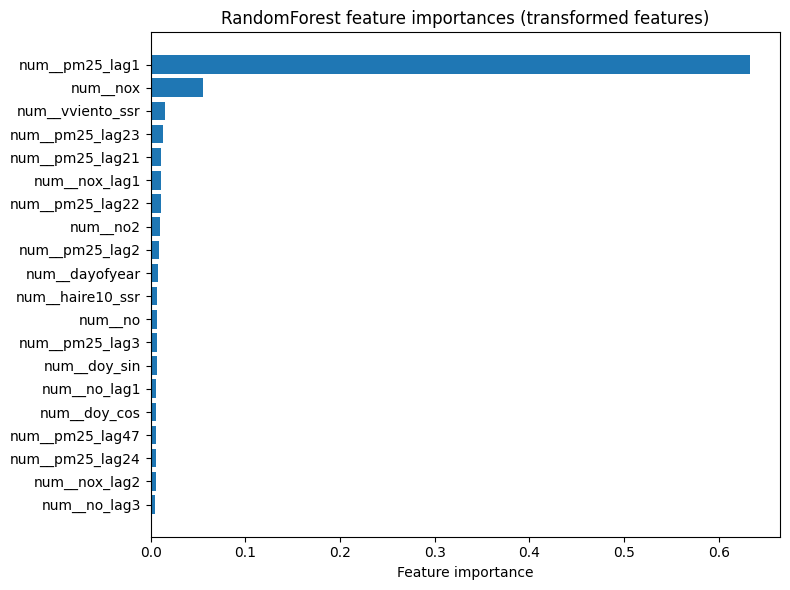

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

importances = rf.feature_importances_
feature_names = preproc.column_transformer_.get_feature_names_out()

# sort
indices = np.argsort(importances)[::-1]

# how many features to show
n_top = 20
top_idx = indices[:n_top]

plt.figure(figsize=(8, 6))
plt.barh(range(n_top), importances[top_idx][::-1])
plt.yticks(range(n_top), [feature_names[i] for i in top_idx][::-1])
plt.xlabel("Feature importance")
plt.title("RandomForest feature importances (transformed features)")
plt.tight_layout()
plt.show()

In [73]:
# Create an importances dataframe

importances_df=pd.DataFrame(importances, index=feature_names, columns=['Importancia'])

In [74]:
important_features=importances_df.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

In [75]:
importances_df.sort_values(by='Importancia',ascending=False).head(20).index.to_list()

['num__pm25_lag1',
 'num__nox',
 'num__vviento_ssr',
 'num__pm25_lag23',
 'num__pm25_lag21',
 'num__nox_lag1',
 'num__pm25_lag22',
 'num__no2',
 'num__pm25_lag2',
 'num__dayofyear',
 'num__haire10_ssr',
 'num__no',
 'num__pm25_lag3',
 'num__doy_sin',
 'num__no_lag1',
 'num__doy_cos',
 'num__pm25_lag47',
 'num__pm25_lag24',
 'num__nox_lag2',
 'num__no_lag3']

In [76]:
important_features_list = [feat.split('__')[-1] for feat in important_features]

In [77]:
important_features_list

['pm25_lag1',
 'nox',
 'vviento_ssr',
 'pm25_lag23',
 'pm25_lag21',
 'nox_lag1',
 'pm25_lag22',
 'no2',
 'pm25_lag2',
 'dayofyear',
 'haire10_ssr',
 'no',
 'pm25_lag3',
 'doy_sin',
 'no_lag1',
 'doy_cos',
 'pm25_lag47',
 'pm25_lag24',
 'nox_lag2',
 'no_lag3']

In [78]:
X_train_small = X_train[:, top_idx]
X_test_small  = X_test_valid[:,  top_idx]
X_val_small   = X_val_valid[:,   top_idx]

In [79]:
rf_small = RandomForestRegressor(
    n_estimators=250,
    max_depth=150,
    random_state=42,
    criterion="squared_error",
    n_jobs=-1
)
rf_small.fit(X_train_small, y_train)

y_test_pred = rf_small.predict(X_test_small)
y_val_pred  = rf_small.predict(X_val_small)

print("Test R2 (small model):", r2_score(y_test_valid, y_test_pred))
print("Val  R2 (small model):", r2_score(y_val_valid,  y_val_pred))

print("Test RMSE (small model):",
      root_mean_squared_error(y_test_valid, y_test_pred))
print("Val  RMSE (small model):",
      root_mean_squared_error(y_val_valid,  y_val_pred))

Test R2 (small model): 0.6217858182185849
Val  R2 (small model): 0.6714351236588729
Test RMSE (small model): 6.974995143712313
Val  RMSE (small model): 6.664576703523584
